<h1 align='center'>ShopSmart Inc. Customer Purchase Analysis</h1>

## Content
[1. Introduction ](#1)

[2. Libraries](#2)
  * [Functions & Configurations](#2.11)

[3. Feature Engineering](#3)
  * [Day](#3.1)
  * [Country]()
  * [Continent](#3.1)
  * [Price Range](#3.1)
  * [Brand](#3.1)
  * [Number of Days Transaction](#3.1)
  * [Total Order Price](#3.1)
  

[4. Exploratory Data Analysis ](#4)
  * [4.1 Question 1](#4.1)
  * [4.2 Question 2](#4.2)
  * [4.3 Question 3](#4.3)


<a id='#1'></a>
**ShopSmart Inc.** is an e-commerce platform that sells a variety of products online. The company aims to optimize its website and enhance customer satisfaction by understanding customer behavior and preferences. 

To achieve this goal, ShopSmart Inc. plans to analyze the data collected from its website to gain insights into customer interactions, purchasing patterns, and product preferences.


Project Objective: The objective of this project is to utilize data from ShopSmart Inc.'s website to understand customer behavior and preferences. By analyzing the data, the company aims to:
1.     Segment customers based on their preferences, geographic location, and purchasing behavior.
2.     Enhance website usability and user experience based on insights gained from customer interactions.
3.     Optimize product offerings and marketing strategies to improve customer satisfaction and retention.



## 2.0 Libraries and Configurations 
<a id="1"></a>

In [1]:
!pip install a-world-of-countries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import missingno
import plotly.graph_objects as go
import plotly.express as px
import awoc
import seaborn as sns
import warnings
from  IPython.display import display,Markdown

In [2]:
warnings.filterwarnings('ignore') # ignores warnings

sns.set_theme(style="white") # Set the theme style to "white"

sns.set_palette("pastel") # Set the palette to "pastel"

def printmd(value):
    """return Markdown"""
    return display(Markdown(value))
    
def get_continent(location):
    """returns continent of country value"""
    for obj in all_countries:
        if obj['Country Name'] == location:
            return obj['Continent Name']
    else:
        if location == 'Korea':
            return 'Asia'
        elif location == 'United States of America':
            return 'North America'
        return 'Other Islands'
        

def added_removed(feature_name1):
    """return dataframe of 'added to cart' products and 'removed from cart' values """
    product_added = pd.pivot(data=new_data[new_data['event_type'] == 'add_to_cart'],
                             values=feature_name1,columns='continent').mode().stack()[0]
    product_removed = pd.pivot(
        data=new_data[new_data['event_type'] == 'remove_from_cart'],
        values=feature_name1, columns='continent').mode().stack()[0]
    product_result = pd.concat([
        product_added,product_removed],axis=1, 
        ignore_index=True,names=['added to cart','removed from cart'])
    
    printmd('Each **CONTINENT** and the product customers **ADDED TO AND REMOVED FROM CART**:\n')
    display(product_result.reset_index().rename(
        columns={'level_0': 'continent', 0: 'added to cart',1:'removed from cart'}))
    print('')

def unlock_df(df_name):
    """extracts json file and returns transformed file as dataframes"""
    new_data = df_name['event_data'].apply(json.loads)
    event_df = pd.DataFrame(item for item in new_data)
    return event_df

def visited_checkout_product(feature_name1):
    """returns visited and checked out values"""
    product_visit = pd.pivot(data=event_visit_type, values=feature_name1, columns='continent').mode().stack()[0]
    product_checkout = pd.pivot(data=checkedout, values=feature_name1, columns='continent').mode().stack()[0]
    product_result = pd.concat([product_visit,product_checkout],axis=1, ignore_index=True,names=['visit','checkout'])
    
    printmd('Each **CONTINENT** and the product customers **VISITED THE MOST**:\n')
    display(product_result.reset_index().rename(columns={'level_0': 'continent', 0: 'most visited brand',1:'most checked out'}))
    print('')
    printmd('Three brands seem to be the most visited in the continents. More of these brands should be made available to the continents and countries.')

def get_percentages(d_series):
    """returns series percentages of input Series values)"""
    return round(d_series/d_series.sum()*100,2)

#### Import data files

In [3]:
customers = pd.read_csv('customers.csv')
events = pd.read_csv('events.csv')
line_items = pd.read_csv('line_items.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  10000 non-null  object
 1   device_id    10000 non-null  object
 2   location     10000 non-null  object
 3   currency     10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15 non-null     int64  
 1   name    15 non-null     object 
 2   price   15 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 492.0+ bytes


In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147208 entries, 0 to 147207
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_id         147208 non-null  int64 
 1   customer_id      147208 non-null  object
 2   event_data       147208 non-null  object
 3   event_timestamp  147208 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.5+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9165 entries, 0 to 9164
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        9165 non-null   object
 1   customer_id     9165 non-null   object
 2   status          9165 non-null   object
 3   checked_out_at  9165 non-null   object
dtypes: object(4)
memory usage: 286.5+ KB


In [8]:
line_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31741 entries, 0 to 31740
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   line_item_id  31741 non-null  int64 
 1   order_id      31741 non-null  object
 2   item_id       31741 non-null  int64 
 3   quantity      31741 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 992.0+ KB


In [9]:
# Merge the customers, events, line_items, orders, and products tables on the customer_id column
merged_data = pd.merge(customers, events, on='customer_id', how='outer') # merged customers and events
merged_data = pd.merge(merged_data, orders, on='customer_id', how='outer') # merged above and customer_id
merged_data = pd.merge(merged_data, line_items, on='order_id', how='outer') # merged above and order_id
merged_data = pd.merge(merged_data, products, left_on='item_id', right_on='id', how='outer') # merged above and item_id

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652958 entries, 0 to 652957
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      652958 non-null  object 
 1   device_id        652958 non-null  object 
 2   location         652958 non-null  object 
 3   currency         652958 non-null  object 
 4   event_id         652958 non-null  int64  
 5   event_data       652958 non-null  object 
 6   event_timestamp  652958 non-null  object 
 7   order_id         645885 non-null  object 
 8   status           645885 non-null  object 
 9   checked_out_at   645885 non-null  object 
 10  line_item_id     578320 non-null  float64
 11  item_id          578320 non-null  float64
 12  quantity         578320 non-null  float64
 13  id               578320 non-null  float64
 14  name             578320 non-null  object 
 15  price            578320 non-null  float64
dtypes: float64(5), int64(1), object(10)
me

In [10]:
merged_data.rename(columns={'name':'product_name', 'location':'country'},inplace=True) # rename some of the column names

In [11]:
# dropping the redundant columns and assigning it to a new variable
new_data = pd.concat([merged_data,unlock_df(merged_data).drop(
    ['status','quantity','order_id','item_id'],axis=1)],axis=1).drop(
    ['event_data','item_id','id','line_item_id','event_timestamp'],axis=1)
new_data.head()

,customer_id,device_id,country,currency,event_id,order_id,status,checked_out_at,quantity,product_name,price,timestamp,event_type
0,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14753,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-21T12:47:11.012084,visit
1,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14754,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-27T11:35:50.208930,visit
2,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14755,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-30T04:03:10.392205,visit
3,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14756,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-30T04:03:10.394393,add_to_cart
4,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14757,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-30T04:03:10.394398,add_to_cart


In [12]:
new_data.to_csv('Sales.csv') # saves merged tables

In [13]:
printmd('**Missing Value Percentages**')
(new_data.isna().sum()/new_data.shape[0]*100).sort_values(ascending=False)

**Missing Value Percentages**

quantity          11.430751
product_name      11.430751
price             11.430751
order_id           1.083224
status             1.083224
checked_out_at     1.083224
customer_id        0.000000
device_id          0.000000
country            0.000000
currency           0.000000
event_id           0.000000
timestamp          0.000000
event_type         0.000000
dtype: float64

In [14]:
new_data.describe().T # numerical features descriptive statistics

,count,mean,std,min,25%,50%,75%,max
event_id,652958.0,88246.576898,42528.242101,14753.00,51324.25,88382.00,125016.00,161960.00
quantity,578320.0,3.009861,1.406914,1.00,2.00,3.00,4.00,5.00
price,578320.0,707.448609,972.915321,5.99,149.95,349.99,899.99,3999.99


In [15]:
new_data.describe(exclude='number').T # numerical features descriptive statistics

,count,unique,top,freq
customer_id,652958,10000,eb7dcb88-073d-403e-bdd4-1e5725fe2338,372
device_id,652958,10000,5d53495a-55ac-49bf-b876-ad1ac4b8d2a4,372
country,652958,243,Korea,7496
currency,652958,3,USD,223367
order_id,645885,9165,5cc9c814-c69a-4831-9b50-92abe2c1dea2,372
status,645885,3,failed,219558
checked_out_at,645885,9165,2024-03-30 04:09:12.797464,372
product_name,578320,15,Canon EOS R5 Camera,39715
timestamp,652958,142501,2024-03-30T04:03:10.735158,24
event_type,652958,4,add_to_cart,302724


In [16]:
printmd(f'The number of duplicate rows = {len(new_data[new_data.duplicated()])}')

The number of duplicate rows = 0

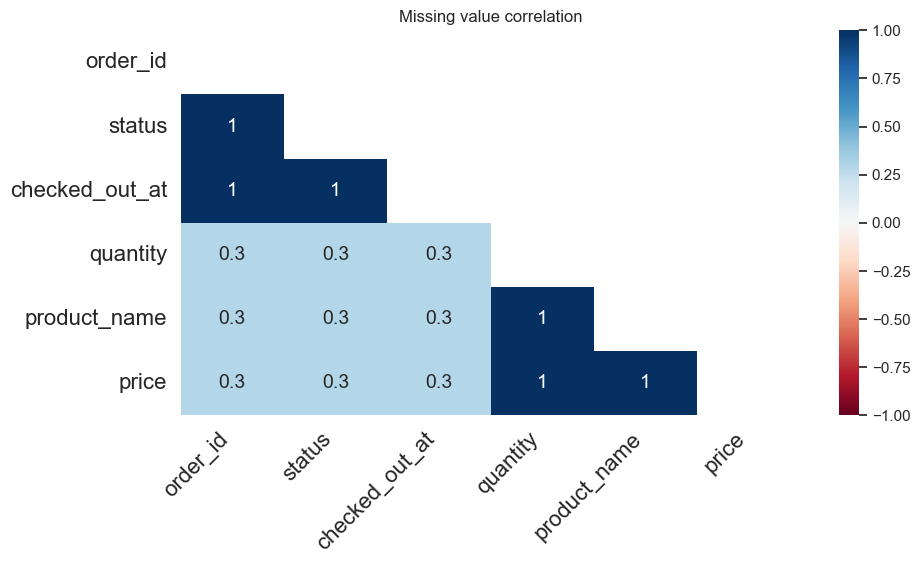

In [17]:
ax = missingno.heatmap(new_data,figsize=(10,5)).set_title('Missing value correlation')

In [18]:
new_data['currency'] = new_data['currency'].astype('category')

### Date Time Transformation

In [19]:
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'],format='%Y-%m-%dT%H:%M:%S.%f')
new_data['checked_out_at'] = pd.to_datetime(new_data['checked_out_at'], format='%Y-%m-%d %H:%M:%S.%f')

In [20]:
total_days = (new_data["timestamp"].max() - new_data["timestamp"].min()).total_seconds()
days = total_days // (24 * 60 *60) # 24 hours * 60 minutes * 60 seconds
remaining_seconds = total_days  % (60*60*24) # 60 minutes * 60 seconds to get the remaining seconds
hours = remaining_seconds // 60 # 60 seconds
result = f"{int(days)} days {int(hours)} hours"

In [21]:
printmd(f'Dataset start date = {new_data["timestamp"].dt.date.min()}')
printmd(f'Dataset end date = {new_data["timestamp"].dt.date.max()}')
printmd(f'Dataset Spanning Through {result}')

Dataset start date = 2024-03-19

Dataset end date = 2024-03-30

Dataset Spanning Through 11 days 16 hours

## 3.0 Feature Engineering
<a id=2></a>

In [22]:
new_data['day'] = new_data['timestamp'].dt.day_name()

In [23]:
country = new_data['country']
country = country.apply(lambda x: x.split('(')[0].strip())
# Replace country names so as to get them from awoc library
country.replace({'United States of America': 'United States',
                     'Congo': 'Democratic Republic of the Congo',
                     "Lao People's Democratic Republic":'Laos',
                     "Brunei Darussalam":'Brunei',
                     "Kyrgyz Republic":'Kyrgyzstan',
                     "Macao":'Macau',
                     "Palestinian Territory":"Palestine",
                     "Syrian Arab Republic":'Syria',
                     "Cote d'Ivoire":'Ivory Coast',
                     'Russian Federation':'Russia',
                     "North Macedonia":'Macedonia', 
                     'South Korea':'Korea',
                     'North Korea':'Korea',
                     'Cocos':'Cocos Islands',
                     "Libyan Arab Jamahiriya":'Libya'}, inplace=True)


In [24]:
all_countries = awoc.AWOC().get_countries() # get dictionary of all countries

In [25]:
new_data['continent'] = country.apply(get_continent)
# new_data['country'].replace({'Democratic Republic of the Congo':'Congo'},inplace=True) # 'Congo' is better for 

In [26]:
new_data['price_range'] = pd.qcut(new_data.price,3, labels=['low','mid','high']) # separating prices into three price range 

In [27]:
new_data['product_name'].replace({'iPhone 13':'Apple iPhone 13'}, inplace=True) # Added brand name to iPhone

In [28]:
new_data['brand'] = new_data['product_name'].apply(lambda x : x.split(' ')[0] if not pd.isna(x) else x) # extract brand name from products

In [29]:
# difference between maximum and minimum timestamp for each customer
new_data['number_of_days_transaction'] = np.ceil(
    new_data.groupby('customer_id')['timestamp'].transform(
        lambda x:np.ptp(x)).dt.total_seconds()/86400) #86400 is the total seconds in a day

In [30]:
new_data['total_order_price'] = new_data['quantity'] * new_data['price']

## 4. Exploratory Data Analysis 
<a id="3"></a>

In [31]:
printmd('Of all transaction performed, **total number of customers** are **{1}** <br> **Total devices** used on the sites are **{0}**'.format(new_data['device_id'].nunique(),new_data['customer_id'].nunique()))
printmd(f'Total number of products are **{products.shape[0]}**')
printmd(f'Total number of Countries are **{len(new_data["country"].unique())}**')
printmd(f'Total number of rows are **{new_data.shape[0]}**')
printmd(f'Total number of columns are **{new_data.shape[1]}**')

Of all transaction performed, **total number of customers** are **10000** <br> **Total devices** used on the sites are **10000**

Total number of products are **15**

Total number of Countries are **243**

Total number of rows are **652958**

Total number of columns are **19**

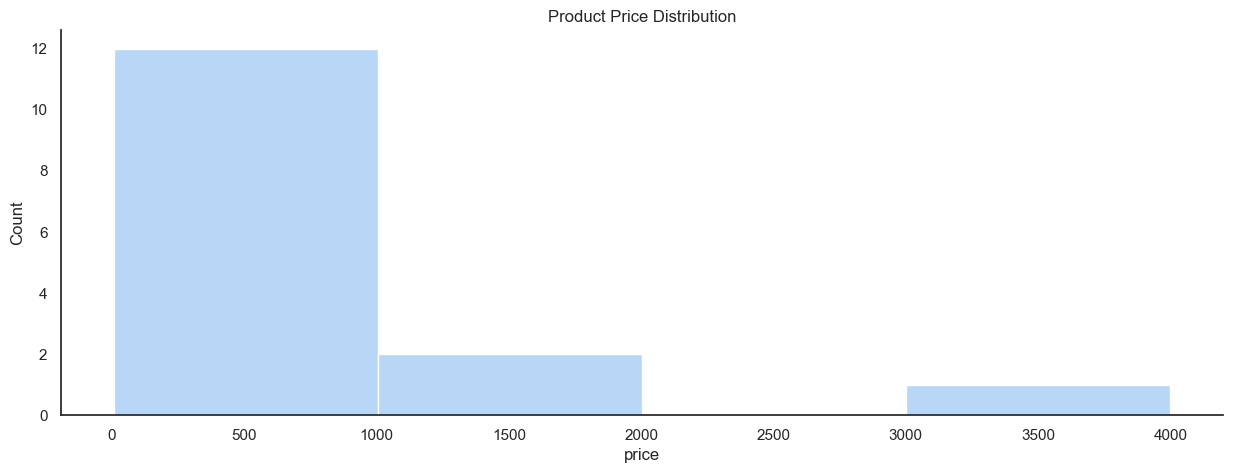

In [32]:
# price distribution
plt.figure(figsize=(15,5))
ax = sns.histplot(products['price'],bins=4)
ax.set_title('Product Price Distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Most (12) of the products prices are within the range of \\$1 to \\$1000 while the remaining products are higher than \$1000 

In [33]:
corr_features = ['quantity','price','number_of_days_transaction']
new_data[corr_features].corr()

,quantity,price,number_of_days_transaction
quantity,1.000000,0.003496,-0.003684
price,0.003496,1.000000,0.008807
number_of_days_transaction,-0.003684,0.008807,1.000000


There is a **negligible positive correlation** between the price and the quantity, \
**Negligible Negative Correlation** between quantity and number of days of transaction

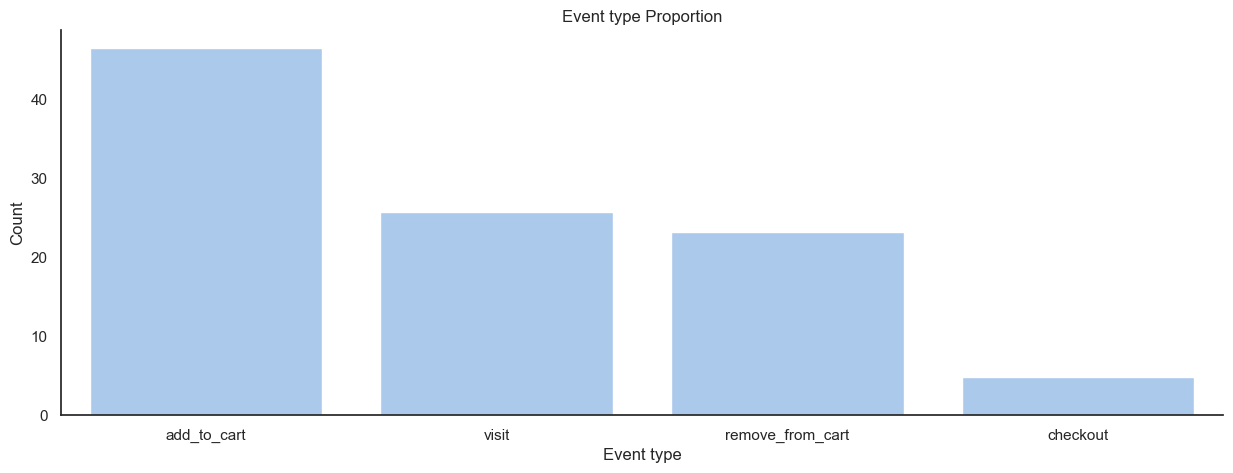

In [34]:
plt.figure(figsize=(15,5))
event_types = new_data['event_type'].value_counts(normalize=True)*100
ax = sns.barplot(event_types)
ax.set_title('Event type Proportion')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Event type')
plt.show()

Total **interactions (652958)** with the website:  
The most event type is that customers added products to cart (\~45%), the number of time they visited (\~25%), removed from cart (\~25%) and checked out (\~5%).

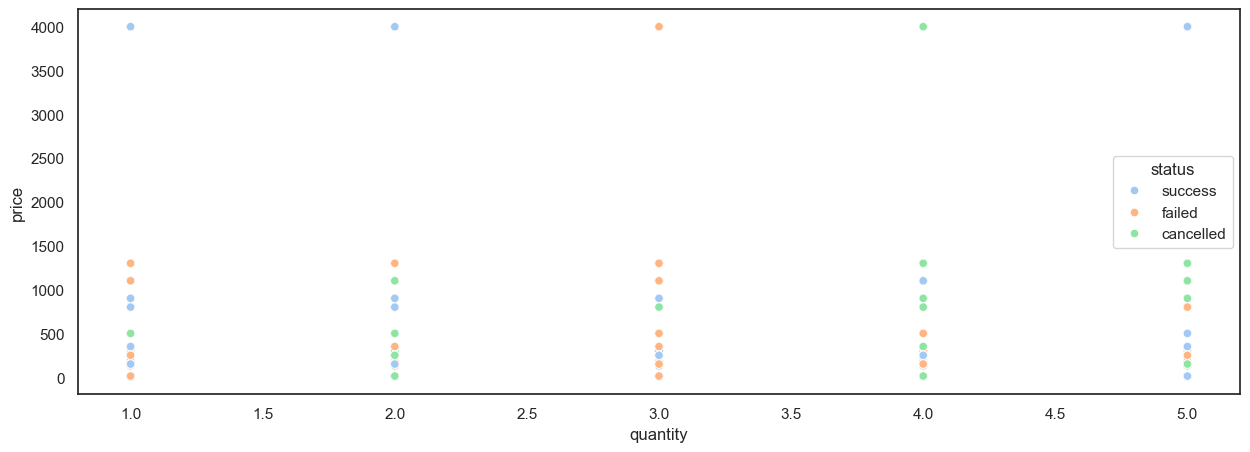

In [35]:
# correlation between price and quantity of product bought
plt.figure(figsize=(15,5))
ax = sns.scatterplot(data=new_data[new_data['event_type'] == 'checkout'], x='quantity',y='price', hue='status')
plt.show()

In [36]:
printmd("There is **no correlation** (pattern) between the **quantity of product** purchased and the **price of the products**") 

There is **no correlation** (pattern) between the **quantity of product** purchased and the **price of the products**

### 4.1 Visit Frequency 
<!-- <a id="3.1"></a> -->
- How often do customer visit the website, based on the provided data?
- Can you identify any patterns or trends in the customer's visit frequency?


In [37]:
#get the event type which are equal to visit
event_visit_type = new_data[new_data['event_type'] == 'visit']
event_visit_type.head()

,customer_id,device_id,country,currency,event_id,order_id,status,checked_out_at,quantity,product_name,price,timestamp,event_type,day,continent,price_range,brand,number_of_days_transaction,total_order_price
0,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14753,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-21 12:47:11.012084,visit,Thursday,Asia,NaN,NaN,9.0,NaN
1,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14754,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-27 11:35:50.208930,visit,Wednesday,Asia,NaN,NaN,9.0,NaN
2,4f4f5adc-1ca2-4b49-bac4-7b12d6d9d5cf,ef424b22-2393-4708-b065-c68152e8b377,Oman,USD,14755,5e57de16-d33c-4126-bf0b-da65449cc3d1,cancelled,2024-03-30 04:12:10.394413,NaN,NaN,NaN,2024-03-30 04:03:10.392205,visit,Saturday,Asia,NaN,NaN,9.0,NaN
9,5cc88463-6a08-48b5-977c-9683a1c607b2,ba53d790-0cfc-4c00-9ab7-a6b104dceb65,United States of America,GBP,14762,62a67177-1d7f-44fe-86f8-622686d68f69,cancelled,2024-03-30 04:15:10.403885,NaN,NaN,NaN,2024-03-19 06:08:39.175184,visit,Tuesday,North America,NaN,NaN,11.0,NaN
10,5cc88463-6a08-48b5-977c-9683a1c607b2,ba53d790-0cfc-4c00-9ab7-a6b104dceb65,United States of America,GBP,14763,62a67177-1d7f-44fe-86f8-622686d68f69,cancelled,2024-03-30 04:15:10.403885,NaN,NaN,NaN,2024-03-26 05:51:26.514840,visit,Tuesday,North America,NaN,NaN,11.0,NaN


In [38]:
# Average number of visits in a day 
number_of_visit = event_visit_type.groupby(['customer_id'])['event_type'].count().sort_values(ascending=False)
max_visits_customers = (number_of_visit[number_of_visit == number_of_visit.max()]).index

In [39]:
# customer(s) with the higest visit
event_visit_type[event_visit_type['customer_id'].isin(max_visits_customers)].groupby('customer_id')['country'].unique()
printmd("There are the customers with the **most visit (120 times)** on the website coming from **United Kingdom, Seychelles, Sri Lanka and 'Wallis and Futuna'**")

There are the customers with the **most visit (120 times)** on the website coming from **United Kingdom, Seychelles, Sri Lanka and 'Wallis and Futuna'**

#### 4.1.1 Visited and Added to Cart vs Visited Only 

In [40]:
visited_n_ordered = event_visit_type.groupby(event_visit_type['order_id'].isna())['customer_id'].nunique()
fig = px.pie(values = visited_n_ordered.values, names=['Order','Didn"t Order'],hole=0.5)
fig.update_layout(title='Customer that Visited and Ordered vs Visited Only')
fig.show()

**91.6%** of the customers that visited did more than just visit, they added to cart, removed and checkedout, though some of the checkouts are not successful and some were successful. 

This may suggest that the products offered by ShopSmart matches a high percentage of their customers  

#### 4.1.2 Visited and Checkedout

In [41]:
visit_status = event_visit_type.groupby('status')['customer_id'].nunique()
fig = go.Figure(data=go.Pie(labels=visit_status.index, values=visit_status, hole=0.5))
fig.update_layout(title = 'Customers that Visited and Checked out with their order status')
fig.show()

In [42]:
printmd('Out of the **1000 customers**, **9165** orders were placed, **successful transaction (32.7%)**, **failed transaction (33.6%)** while **cancelled (33.7%)** ')
printmd('The likelihood of a customer visiting and successfully purchasing a product is low as the amount of failed and cancelled are more than the number of success')

Out of the **1000 customers**, **9165** orders were placed, **successful transaction (32.7%)**, **failed transaction (33.6%)** while **cancelled (33.7%)** 

The likelihood of a customer visiting and successfully purchasing a product is low as the amount of failed and cancelled are more than the number of success

#### 4.1.3 VIsit Day and Time

#### 4.1.4 Number of days customers used in visiting

In [43]:
visit_day_number = event_visit_type.groupby('number_of_days_transaction')['customer_id'].nunique()
percentages = get_percentages(visit_day_number)
fig = px.bar(x=visit_day_number.index,y=visit_day_number.values,text=percentages.apply(lambda x :str(x) + '%'))
median_median = event_visit_type.groupby('customer_id')['number_of_days_transaction'].median().median()
fig.add_vline(x=median_median, line_dash="dash", line_color="lightblue", annotation_text=f'Median: {median_median}', annotation_position="top right")

fig.update_layout(title='Number of visits days by customers',xaxis_title='Number of Days of Transaction',yaxis_title='Count')
fig.update_traces(hovertemplate="day of transaction = %{x}, number of customers visit = %{y}",textposition='auto')
fig.show()

In [44]:
printmd(f"**{percentages.iloc[0]}%** of the customers visited the website for **just one day** while it can be seen that there is an increase in some customers visit after **day 2** till **day 11** after which there is almost absolute drop to zero. \nThe means that customers\
    **that dont finish their transaction on same day may take up to 11 days to** to make decision on the products they want to purchase")
printmd('The transaction days median value is the first day which also support the fact that **most visits lasts a day**')

**50.31%** of the customers visited the website for **just one day** while it can be seen that there is an increase in some customers visit after **day 2** till **day 11** after which there is almost absolute drop to zero. 
The means that customers    **that dont finish their transaction on same day may take up to 11 days to** to make decision on the products they want to purchase

The transaction days median value is the first day which also support the fact that **most visits lasts a day**

In [45]:
all_daily_interactions = event_visit_type['timestamp'].dt.day_name().value_counts() # counts number of interactions of customers on each day
customer_interaction = event_visit_type.groupby('day')['customer_id'].nunique().sort_values(ascending=False) # counts unique customer id for each day

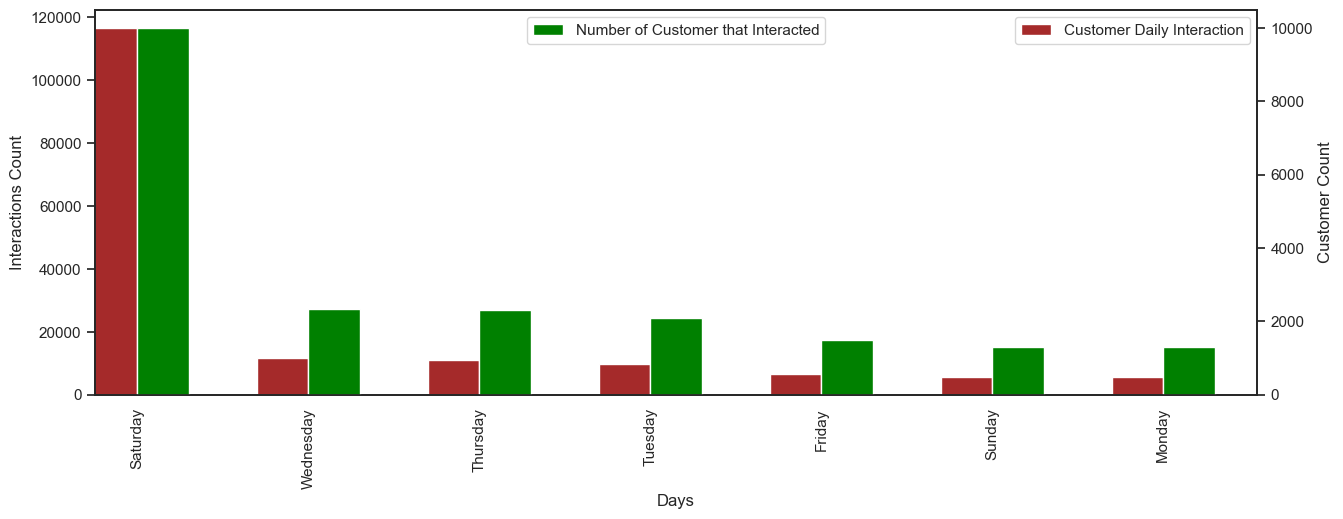

In [46]:
fig = plt.figure(figsize=(15,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

all_daily_interactions.plot(kind='bar', color='brown', ax=ax, width=width, position=1,label='Customer Daily Interaction')
customer_interaction.plot(kind='bar', color='green', ax=ax2, width=width, position=0,label='Number of Customer that Interacted')

ax.set_ylabel('Interactions Count')
ax2.set_ylabel('Customer Count')

ax.set_xlabel('Days')

ax.legend(loc='upper right')
ax2.legend(loc='upper center')
plt.savefig('not_stacked.png')

**Saturday** is the day **all Customers (10000) visited the website** and also the day **most interaction occurred (>115 000)**

Though **Sunday** is the **least day** with interactions **(5602)** but the data shows that **Monday** is the actual day the **least amount of customers (1302) visit the website**

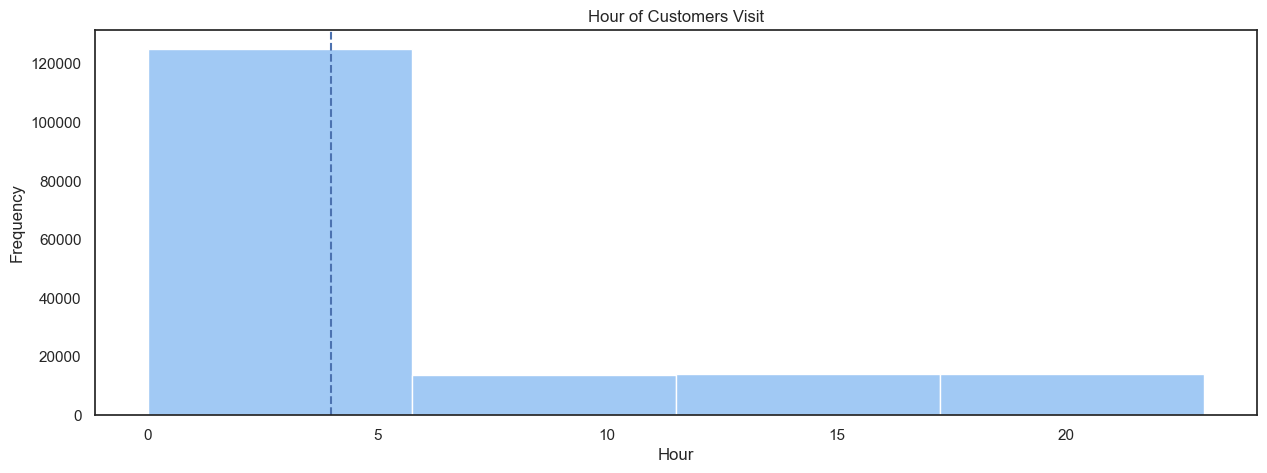

Customers visit the websites mostly during the <b>FIRST QUARTER</b> of the day which is between <b>12 AM</b> to <b>6 AM</b> and the **highest visit** being <b>4 AM hour</b>

In [47]:
ax = event_visit_type['timestamp'].dt.hour.plot(kind='hist',bins=4,figsize=(15,5))
mode_hour = new_data['timestamp'].dt.hour.mode()[0]
plt.axvline(mode_hour, color='b', linestyle='--', label='Most visits Hour')
plt.title('Hour of Customers Visit')
ax.set_xlabel('Hour')
plt.show()

printmd('Customers visit the websites mostly during the <b>FIRST QUARTER</b> of the day which is between <b>12 AM</b> to <b>6 AM</b> and the **highest visit** being <b>4 AM hour</b>')

#### 4.1.5 Continents and Countries of visits

In [48]:
visit_continent = event_visit_type.groupby('continent')['customer_id'].nunique().sort_values(ascending=False)
percentages = get_percentages(visit_continent)
fig = go.Figure(data=go.Bar(x=visit_continent.index, y=visit_continent.values, text=percentages.apply(lambda y :str(y) + '%')))
fig.update_layout(title = 'Visit by Continent of customers')
fig.show()

In [49]:
printmd(f'Most of the visits to the website are customers from **{percentages.index[0]} ({percentages.values[0]}%)**,**{percentages.index[1]} ({percentages.values[1]}%)** and **{percentages.index[2]}({percentages.values[2]}%)** making the **top 3** of the continents that visits the website')

printmd("Customers from **Africa**, are the **highest visitor**, followed by Asian customers and Europe, the place where customers are least is the Antarctica, This is expected as the amount of counrties in Africa are more than than Asia and Asia are more than others")

Most of the visits to the website are customers from **Africa (22.72%)**,**Asia (21.49%)** and **Europe(19.82%)** making the **top 3** of the continents that visits the website

Customers from **Africa**, are the **highest visitor**, followed by Asian customers and Europe, the place where customers are least is the Antarctica, This is expected as the amount of counrties in Africa are more than than Asia and Asia are more than others

In [50]:
visit_country = event_visit_type.groupby('country')['customer_id'].nunique().sort_values(ascending=False)
percentages = get_percentages(visit_country)
fig = go.Figure(data=go.Bar(x=visit_country[:10].index, y=visit_country[:10].values, text=percentages.apply(lambda y :str(y) + '%')))
fig.update_layout(title = 'Visit by Continent of customers Top 10')
fig.show()

In [51]:
# customer_visit
product_visit = pd.pivot(data=event_visit_type, values='product_name', columns='country').mode().stack()[0].reset_index(name='most visited product')
customer_visit = pd.merge(event_visit_type.groupby('country')['customer_id'].nunique().reset_index(name='count'),product_visit,on='country')
customer_visit.head()

,country,count,most visited product
0,Afghanistan,40,Canon EOS R5 Camera
1,Albania,42,Samsung Galaxy S21
2,Algeria,46,Sony PlayStation 5
3,American Samoa,36,Microsoft Xbox Series X
4,Andorra,48,Canon EOS R5 Camera


In [52]:
fig = go.Figure(data=go.Choropleth(
    locations = customer_visit['country'],
    locationmode='country names',
    z = customer_visit['count'],
    colorscale = 'amp_r',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Customer count',
    hovertemplate='Country:<b> %{location}</b><br>Customer count:<b> %{z}</b><br>'
                  'Most visited product:<b> %{customdata}</b><extra></extra>',
    customdata=customer_visit['most visited product']
    ))

fig.update_layout(
    title_text='Customers Visits by Country with most visited Product',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

#### 4.1.6 Most visited brand and Products

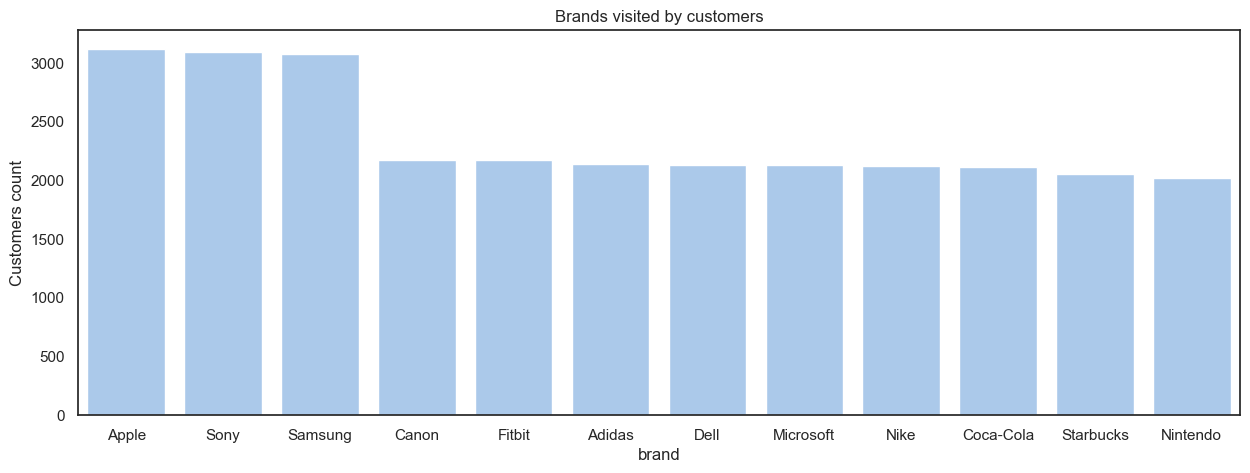

In [53]:
brand_customers_visit = event_visit_type.groupby('brand')\
['customer_id'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15,5))
ax = sns.barplot(brand_customers_visit)
ax.set_title('Brands visited by customers')
ax.set_ylabel('Customers count')
plt.show() 

In [54]:
printmd('During the customers visit, **Apple, Sony and Samsung** brands are the **most interacted with**.\
    The brands with high value are obvious because they have products which is more than one.<br>\
        As such it is advised that ShopSmart get **more products from these brands** can generate more revenue')

During the customers visit, **Apple, Sony and Samsung** brands are the **most interacted with**.    The brands with high value are obvious because they have products which is more than one.<br>        As such it is advised that ShopSmart get **more products from these brands** can generate more revenue

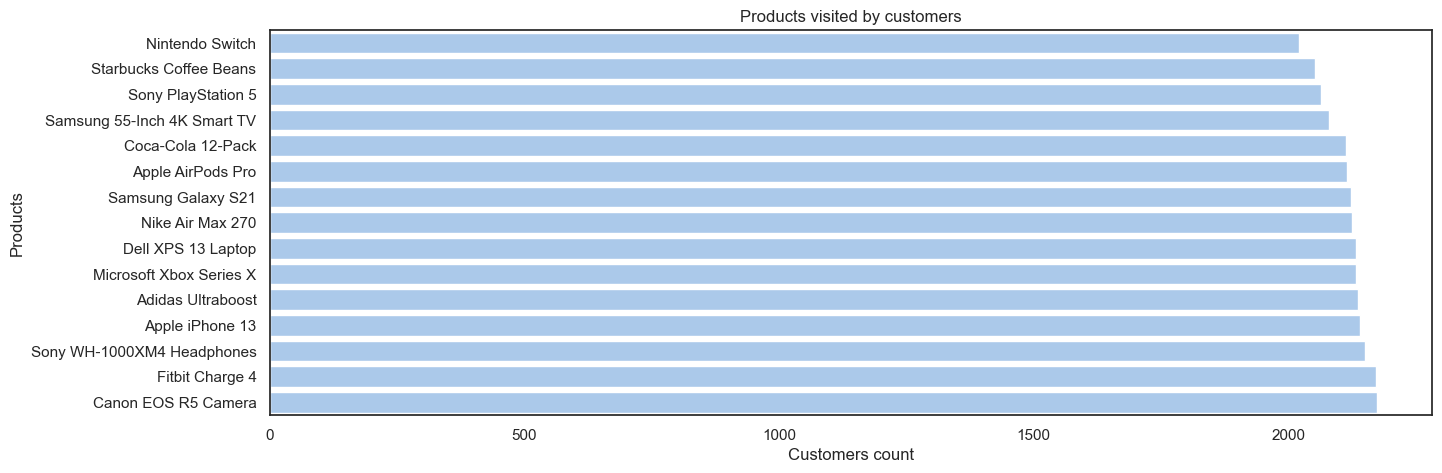

The visit difference between the products are not quite much so it can be said that all ShopSmart Products are wanted by the customers


In [55]:
product_customers_visit = event_visit_type.groupby('product_name')\
['customer_id'].nunique().sort_values()
plt.figure(figsize=(15,5))
ax = sns.barplot(product_customers_visit,orient='h')
ax.set_title('Products visited by customers')
ax.set_ylabel('Products')
ax.set_xlabel('Customers count')
plt.show()
print("The visit difference between the products are not quite much so it can be said that all ShopSmart Products are wanted by the customers")

<a id="4.2"></a>
### 4.2 Location Analysis:
- What is the customer's location based on the provided data?
- How might the customer's location influence their purchasing behavior?


#### 4.2.1 customers location

#### 4.2.1 Most visited Products by Country and Continent

In [56]:
product_visit = pd.pivot(data=event_visit_type, values='brand',
                         columns='continent').mode().stack()[0]
product_checkout = pd.pivot(data=new_data[(new_data['event_type'] == 'checkout')], values='brand',
                            columns='continent').mode().stack()[0]
product_result = pd.concat([product_visit,product_checkout],axis=1,
                           ignore_index=True,names=['visit','checkout'])

printmd('Each **CONTINENT** and the product customers **VISITED THE MOST**:\n')
display(product_result.reset_index().rename(columns={'level_0': 'continent', 0: 'most visited brand',1:'most checked out'}))
printmd('Three brands seem to be the most visited in the continents. If the **continent\'s most checked out product** and **most visited products are the same**, more of those brands/products should be made available to the continents and countries.')

Each **CONTINENT** and the product customers **VISITED THE MOST**:


,continent,most visited brand,most checked out
0,Africa,Apple,Apple
1,Antarctica,Samsung,Samsung
2,Asia,Apple,Apple
3,Europe,Sony,Samsung
4,North America,Samsung,Sony
5,Oceania,Samsung,Apple
6,Other Islands,Samsung,Samsung
7,South America,Apple,Sony


Three brands seem to be the most visited in the continents. If the **continent's most checked out product** and **most visited products are the same**, more of those brands/products should be made available to the continents and countries.

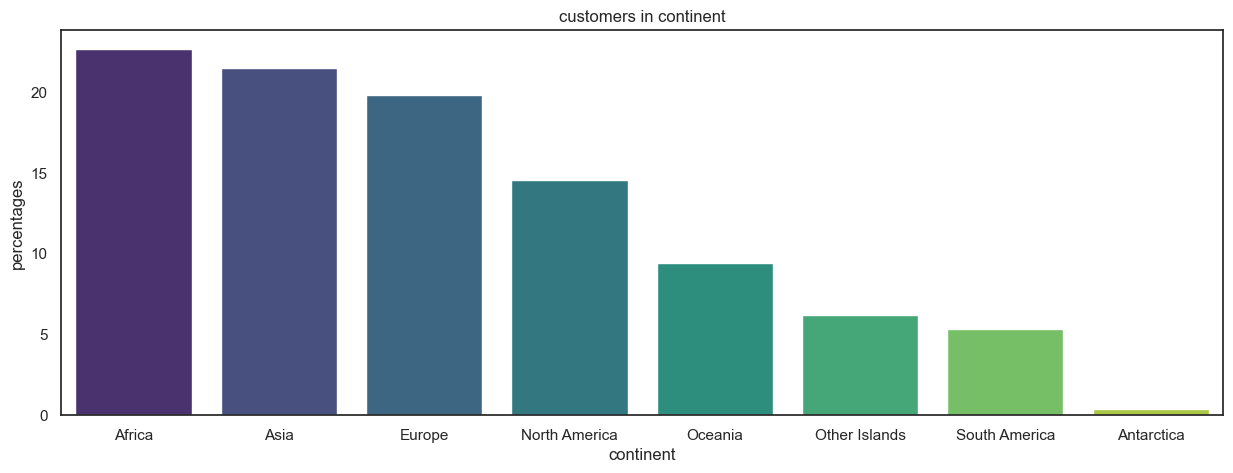

In [57]:
new_data_location = new_data.groupby(['continent'])['customer_id'].nunique().sort_values(ascending=False).reset_index(name='count')
new_data_location['percentages'] = new_data_location['count'].div(new_data_location['count'].sum())*100
plt.figure(figsize=(15,5))
sns.barplot(new_data_location[:10], x='continent', y = 'percentages', hue='continent',palette='viridis')
plt.title('customers in continent')
plt.show()

In [58]:
printmd(f"Out of the **{new_data['country'].unique().shape[0]}** Countries, **22.72%** of them are **Africans**, followed by **Asia** with **21.49%** of the customers while **Antarctica (0.36)%** which is the least")

Out of the **243** Countries, **22.72%** of them are **Africans**, followed by **Asia** with **21.49%** of the customers while **Antarctica (0.36)%** which is the least

#### 4.2.1 Purchase Status of Customers by Continent

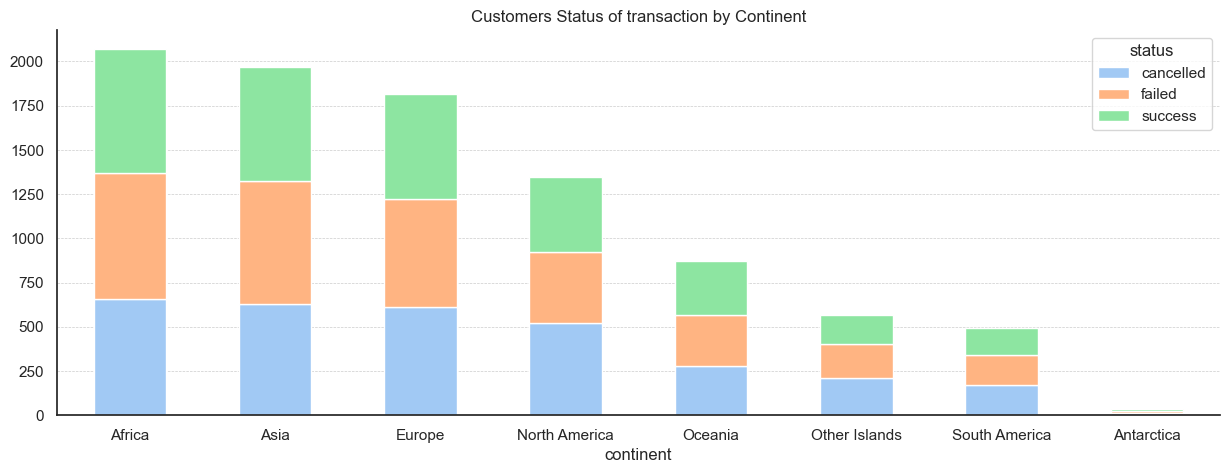

In [59]:
ax = new_data.groupby(['continent','status'])['customer_id'].nunique().unstack().sort_values(by=['failed','cancelled','success'], ascending=False).plot(kind='bar', stacked=True, figsize=(15,5))
plt.xticks(rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.title('Customers Status of transaction by Continent')
plt.savefig('customer_loc_status.png')

Africa has the highest transaction rate, followed by Asia and Europe. 

The Cancelled rate for these continents are fairly the same, but loooking at ther failed status their is reduction in the customers numbers,

while the 3 top continents also have nearly same amount of success checkout

#### Event type and Location

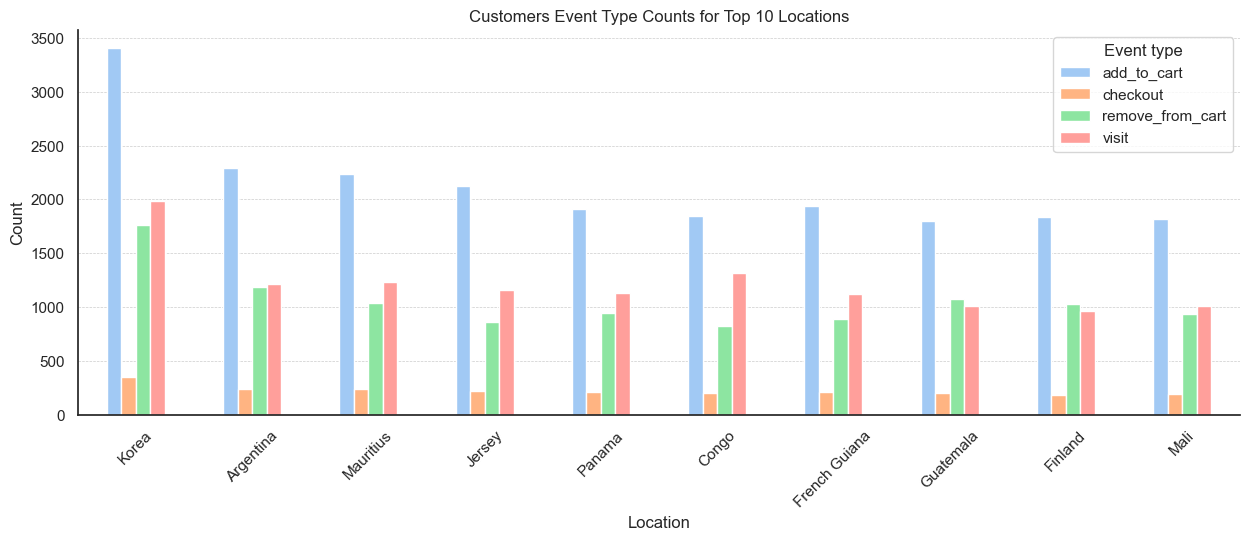

In [60]:
res = new_data.groupby(['country','event_type']).size().unstack()
res_total = res.sum(1).sort_values(ascending=False)
res = res.reindex(res_total.index)


ax = res[:10].plot(kind='bar', stacked=False,figsize=(15,5)) #plot top 10 locations and their status
plt.xlabel('Location')
plt.ylabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.title('Customers Event Type Counts for Top 10 Locations')
plt.legend(title='Event type')
plt.show()

#### Most Added to cart and Removed Product

In [61]:
added_removed('brand')
added_removed('product_name')

Each **CONTINENT** and the product customers **ADDED TO AND REMOVED FROM CART**:


,continent,added to cart,removed from cart
0,Africa,Sony,Sony
1,Antarctica,Apple,Samsung
2,Asia,Apple,Apple
3,Europe,Samsung,Samsung
4,North America,Sony,Sony
5,Oceania,Samsung,Samsung
6,Other Islands,Samsung,Samsung
7,South America,Sony,Sony


Each **CONTINENT** and the product customers **ADDED TO AND REMOVED FROM CART**:


,continent,added to cart,removed from cart
0,Africa,Canon EOS R5 Camera,Canon EOS R5 Camera
1,Antarctica,Coca-Cola 12-Pack,Samsung 55-Inch 4K Smart TV
2,Asia,Samsung Galaxy S21,Samsung Galaxy S21
3,Europe,Fitbit Charge 4,Fitbit Charge 4
4,North America,Canon EOS R5 Camera,Canon EOS R5 Camera
5,Oceania,Fitbit Charge 4,Fitbit Charge 4
6,Other Islands,Samsung 55-Inch 4K Smart TV,Microsoft Xbox Series X
7,South America,Dell XPS 13 Laptop,Dell XPS 13 Laptop


In [62]:
printmd('Three brands seem to be the most visited in the continents. More of these brands should be made available to the continents and countries.')

Three brands seem to be the most visited in the continents. More of these brands should be made available to the continents and countries.

<br> 

### 4.3 Overall Purchase Behavior: 
<a id='4.3'></a>

- Based on the data provided, what insights can you draw about this customer's overall behavior on the website?

- How might these insights inform marketing strategies or personalized recommendations for this customer?


In [63]:
# Orders checked out only
checkedout_only = new_data[(new_data['event_type'] =='checkout')]

# success status and checkout event type
success_checkout = new_data[(new_data['status'] == 'success')&(new_data['event_type'] == 'checkout')] 
success_checkout.head()

,customer_id,device_id,country,currency,event_id,order_id,status,checked_out_at,quantity,product_name,price,timestamp,event_type,day,continent,price_range,brand,number_of_days_transaction,total_order_price
74651,cda7bec0-7cbf-4145-baf9-e049bab94504,33b485de-7338-4997-b1d0-b988ba17b245,Saint Helena,NGN,14799,9e950ce3-2e12-479c-a051-493c1a497d49,success,2024-03-30 04:19:10.406794,2.0,Microsoft Xbox Series X,499.99,2024-03-30 04:19:10.406794,checkout,Saturday,Africa,mid,Microsoft,4.0,999.98
74673,11f73687-45ab-4665-9b1a-14356a593623,aefb983d-2b30-4e1b-97c1-3816f2aafd9d,Grenada,GBP,14935,bb15e304-1f09-4360-85da-1bbf58aa9669,success,2024-03-30 04:13:10.429566,2.0,Microsoft Xbox Series X,499.99,2024-03-30 04:13:10.429566,checkout,Saturday,North America,mid,Microsoft,10.0,999.98
74766,dd5ee53d-d40c-4c6b-b4de-730f60e253ea,154f5606-e68a-48a5-8c63-0fd5d26e632f,French Guiana,GBP,15258,b32b9260-7816-4bcf-a4d1-c4d3185a7e18,success,2024-03-30 04:20:10.473494,1.0,Microsoft Xbox Series X,499.99,2024-03-30 04:20:10.473494,checkout,Saturday,Other Islands,mid,Microsoft,11.0,499.99
74825,d243e1f3-0d18-4d9d-ac1a-2f9e132357ef,6df259de-262a-4631-a43f-49eee28554d7,Canada,NGN,15320,86f98785-8baa-412e-9978-4be50f61a119,success,2024-03-30 04:19:10.477760,1.0,Microsoft Xbox Series X,499.99,2024-03-30 04:19:10.477760,checkout,Saturday,North America,mid,Microsoft,11.0,499.99
74881,463e0e34-17be-49e3-9af4-46e6d9666fd7,ee1e261a-6637-4566-9ff5-cc8287082d0f,Chad,GBP,15590,0f6ba96a-ab4f-416f-be1c-fc045facee74,success,2024-03-30 04:17:10.493141,4.0,Microsoft Xbox Series X,499.99,2024-03-30 04:17:10.493141,checkout,Saturday,Africa,mid,Microsoft,1.0,1999.96


In [64]:
printmd(f'Total of Customers who checked out are **{checkedout_only["customer_id"].nunique()} out of 10000 customers**')

Total of Customers who checked out are **4594 out of 10000 customers**

In [65]:
checkedout_only.groupby(['status'])['customer_id'].nunique()

status
cancelled    1524
failed       1522
success      1548
Name: customer_id, dtype: int64

In [66]:
checkedout_only.groupby(['status'])['customer_id'].nunique()

status
cancelled    1524
failed       1522
success      1548
Name: customer_id, dtype: int64

Text(0.5, 1.0, 'Customers Checked out Status Proportion')

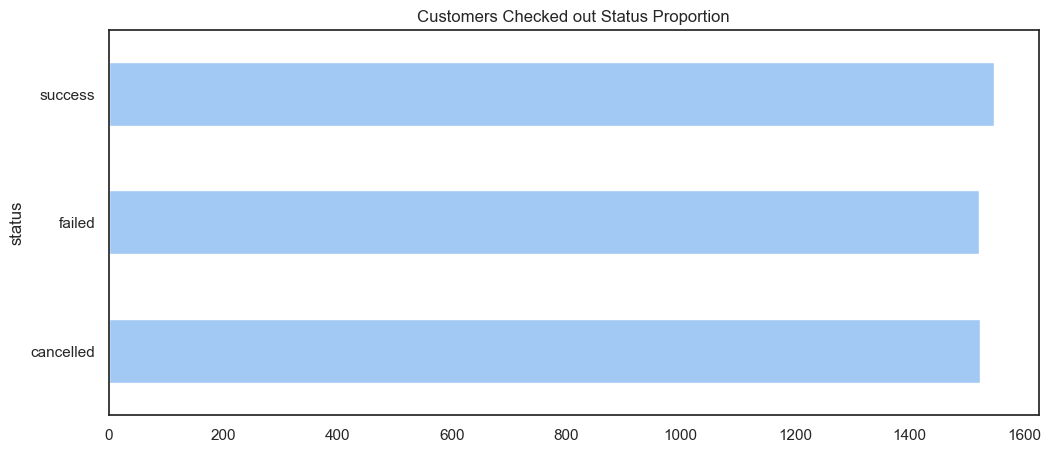

In [67]:
checkedout_only.groupby(['status'])['customer_id'].nunique().plot(kind='barh', figsize=(12,5))
plt.title('Customers Checked out Status Proportion')

In [68]:
printmd('The status of Customers Order shows that the difference between the 3 status types are not quite much but success edges the failed and the cancelled out by a little')

The status of Customers Order shows that the difference between the 3 status types are not quite much but success edges the failed and the cancelled out by a little

#### Success Status Customers 

In [69]:
success_customers = success_checkout['customer_id'].nunique()
event_visit_type['customer_id'].nunique()
printmd(f"Total number of those who successfully checked out are **{success_customers}** which is **{success_checkout['customer_id'].nunique()/event_visit_type['customer_id'].nunique()*100:.2f}%** of the total customers that visited the website")

Total number of those who successfully checked out are **1548** which is **15.48%** of the total customers that visited the website

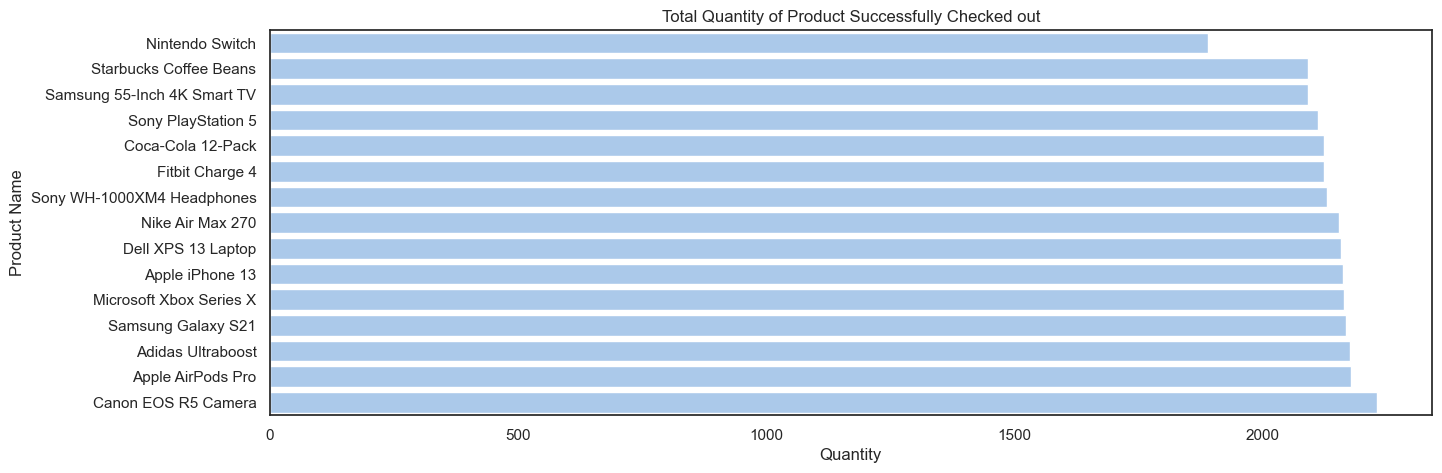

Most of the products purchased quantity are more than 2000 with Canon EOS R5 Camera taking the lead and the least quantity is the Nintendo Switch

This suggests that the **market for Nintendo Switch Product is not as much as the market for other products**

In [70]:
# success_checkout_quantity
quantity_count = success_checkout.groupby('product_name')['quantity'].sum().sort_values()
plt.figure(figsize=(15,5))

ax = sns.barplot(y=quantity_count.index,x=quantity_count.values,orient='horizontal')
ax.set_title('Total Quantity of Product Successfully Checked out')
ax.set_ylabel('Product Name')
ax.set_xlabel('Quantity')
plt.show()
printmd('Most of the products purchased quantity are more than 2000 with Canon EOS R5 Camera taking the lead and the least quantity is the Nintendo Switch')
printmd('This suggests that the **market for Nintendo Switch Product is not as much as the market for other products**')

#### 4.3.1 Checkouts and Revenue with respect to number of transaction days

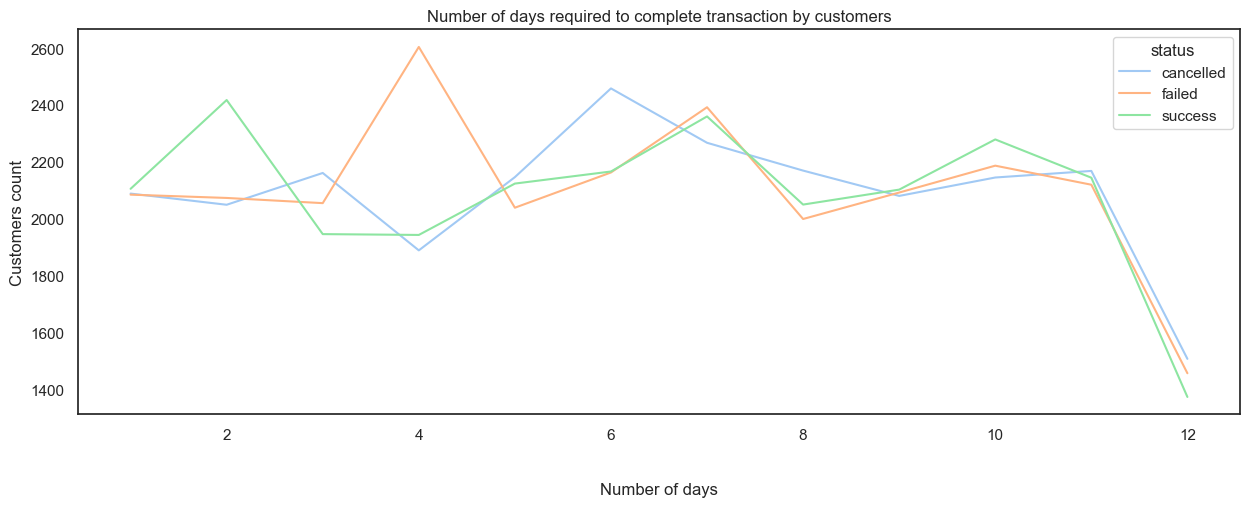

Failed Purchase after day 3 days is on the high, products that can make the Customer to checkout instantly may be introduced  

In [71]:

result = checkedout_only.groupby(['number_of_days_transaction','status'])['total_order_price'].mean().unstack()
result.plot(kind='line',figsize=(15,5))
plt.ylabel('Customers count')
plt.xlabel('\n\nNumber of days')
plt.title('Number of days required to complete transaction by customers')
plt.show()
printmd('Failed Purchase after day 3 days is on the high, products that can make the Customer to checkout instantly may be introduced  ')

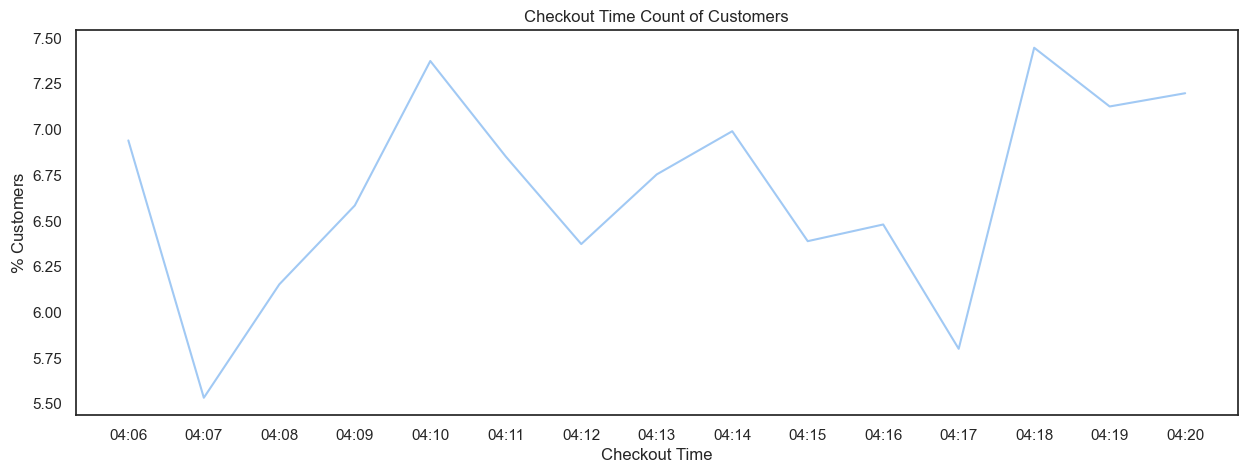

In [72]:
# Checkout time 
time_checkout = new_data[new_data['event_type'] == 'checkout']['checked_out_at'].dt.time.apply(
    lambda x:x.strftime('%H:%M')).value_counts(normalize=True).sort_index()
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = time_checkout*100)
ax.set_xlabel('Checkout Time')
ax.set_ylabel('$\%$ Customers')
ax.set_title('Checkout Time Count of Customers')
plt.show()

Many Customers who use than an average of **2 days** complete their transaction successfully  
Transactions on **day 4** to **day 6** are likely to get **cancelled or fail**  
Transactions of more than **2 days** should be reminded Customers about their purchase so they dont forget

In [73]:
printmd(f'The **average checkout** is **{success_checkout["checked_out_at"].mean().strftime("%H:%M")} AM**')
printmd(f"Of {success_customers} customers, **~7.4%** checked out at **04:18 AM** (most checkout) and **~5.5%** (least checkout) of the customers checked out at **04:08 AM**")

The **average checkout** is **04:13 AM**

Of 1548 customers, **~7.4%** checked out at **04:18 AM** (most checkout) and **~5.5%** (least checkout) of the customers checked out at **04:08 AM**

#### 4.3.2 Sum of Product Quantity Successfully Checked out

In [74]:
result=success_checkout.groupby('country')['customer_id'].nunique().sort_values(ascending=False)
percentages = get_percentages(result)
fig = px.bar(x=result.index[:10],y=result.values[:10],
             text=percentages[:10].apply(lambda x :str(x) + '%'))

fig.update_layout(title='Top 10 Countries with Customers Successful Order',xaxis_title='Country',yaxis_title='Count')
fig.show()

In [75]:
printmd(f'Out of **{result.sum()}** Customers that successfully purchased, **{percentages[0]}%** of customers from **{result.index[0]}**, **{percentages[1]}%** from **{result.index[1]}**, **{percentages[2]}%** from **{result.index[2]}** of customers while the least **{percentages[-1]}%** is from **{percentages.index[-1]}**')

Out of **1548** Customers that successfully purchased, **1.1%** of customers from **Korea**, **1.03%** from **Mauritius**, **0.84%** from **Albania** of customers while the least **0.06%** is from **Slovenia**

In [76]:
# Successfully Ordered Product Quantity by Continent
continent_status_rate = pd.pivot_table(
    data=new_data[new_data['event_type'] == 'checkout'],
    columns='continent', values='quantity',index = 'status',aggfunc='sum')

# Calculate percentages
total_counts = continent_status_rate.sum(axis=0)
percentages = (continent_status_rate.div(total_counts, axis=1) * 100).round(2)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=continent_status_rate.values,
    x=percentages.columns,
    y=percentages.index,
    colorscale='oryel',
    colorbar=dict(title='Percentage')
))

for i in range(len(percentages.index)):
    for j in range(len(percentages.columns)):
        fig.add_annotation(
            x=percentages.columns[j],
            y=percentages.index[i],
            text=str(percentages.values[i, j]) + '%',
            showarrow=False,
            font=dict(color='white'))

# Update layout
fig.update_layout(
    title='Successsfuly Ordered Product Quantity by Continent',
    xaxis_title='Continent',
    yaxis_title='Status'
)

# Show figure
fig.show()


#### 4.3.3 Currency Customers make payment in correlation with Status

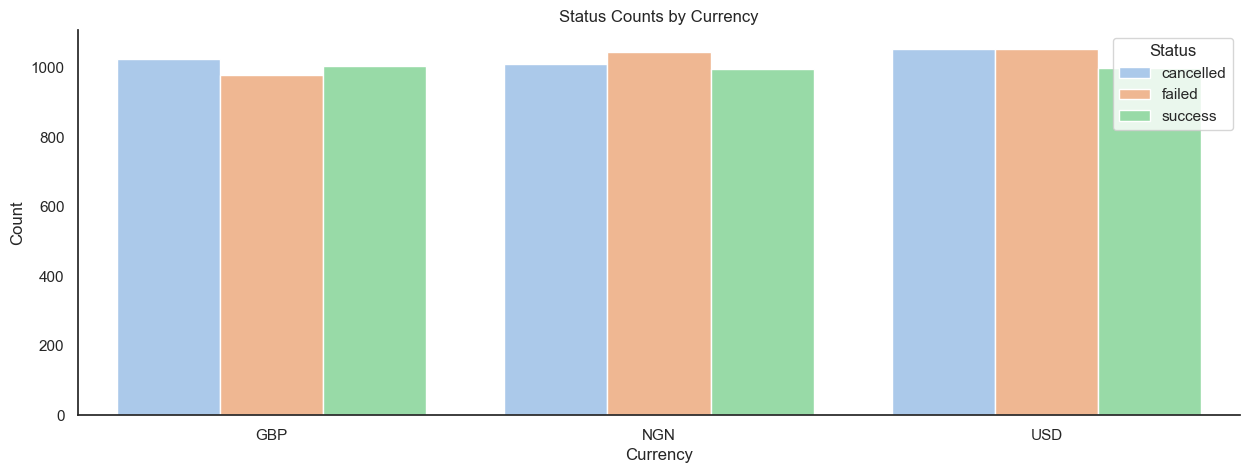

In [77]:
plt.figure(figsize=(15, 5))
customer_currency = new_data.groupby(['currency', 'status'])['customer_id'].nunique().reset_index()
ax = sns.barplot(data=customer_currency, x='currency', y='customer_id', hue='status')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Currency')
plt.ylabel('Count')
plt.title('Status Counts by Currency')
plt.legend(title='Status')
plt.show()


Though the difference for some of the currency used in purchase transaction is not quite much, **NGN** shows to have the most failed purchase transactions compared to the cancelled and success rate followed by **USD** and **GBP** which seems to be the most reliable.

#### 4.3.4 Removed From Cart

In [78]:
removed_from_cart = new_data[new_data['event_type'] == 'remove_from_cart'].groupby(['product_name'])['customer_id'].nunique().sort_values()
printmd('**Count of Customer for product removed from Cart:**')
# removed_from_cart/removed_from_cart.sum()*100
removed_from_cart

**Count of Customer for product removed from Cart:**

product_name
Nintendo Switch                1975
Starbucks Coffee Beans         1999
Sony PlayStation 5             2007
Samsung 55-Inch 4K Smart TV    2033
Apple AirPods Pro              2054
Coca-Cola 12-Pack              2061
Apple iPhone 13                2062
Adidas Ultraboost              2065
Microsoft Xbox Series X        2067
Samsung Galaxy S21             2068
Dell XPS 13 Laptop             2073
Nike Air Max 270               2081
Sony WH-1000XM4 Headphones     2086
Canon EOS R5 Camera            2117
Fitbit Charge 4                2122
Name: customer_id, dtype: int64

In [79]:
printmd('A total of <b>Customers 2122 customers</b> removed **fitbit charge 4** from cart  <br><b>1975 customers</b> removed **Nintendo Switch**' )

A total of <b>Customers 2122 customers</b> removed **fitbit charge 4** from cart  <br><b>1975 customers</b> removed **Nintendo Switch**

In [80]:
# most revenue by brand 
most_revenue_by_brand = new_data[(new_data['status'] == 'success') & (new_data['event_type'] == 'checkout')].groupby('brand')['total_order_price'].sum().sort_values(ascending=False)
total_revenue = most_revenue_by_brand.sum()
percentages = get_percentages(most_revenue_by_brand)
fig = px.bar(x=most_revenue_by_brand.index, y=most_revenue_by_brand.values, text=percentages.apply(lambda y :str(y) + '%'), height=400, width=900)
fig.update_layout(title='Successfully Purchased Brands and Their Revenue')
fig.update_yaxes(title_text='Revenue')
fig.update_xaxes(title_text='Brand')
fig.show()


#### 4.3.5 Revenue of Successfuly Purchased Products

In [81]:

result = success_checkout.groupby('product_name')['total_order_price'].sum().sort_values(ascending=False)
percentages = get_percentages(result)
fig = px.bar(x=result.index, y=result.values, text=percentages.apply(lambda y :str(y) + '%'), height=400, width=900)
fig.update_layout(title='Successfully Purchased Product and Their Revenue')
fig.update_yaxes(title_text='Revenue')
fig.update_xaxes(title_text='Product')
fig.show()

In [82]:
print(f'Total Revenue is ${round(total_revenue,2)}')
quantity_count

Total Revenue is $22760347.19


product_name
Nintendo Switch                1891.0
Starbucks Coffee Beans         2092.0
Samsung 55-Inch 4K Smart TV    2093.0
Sony PlayStation 5             2112.0
Coca-Cola 12-Pack              2124.0
Fitbit Charge 4                2124.0
Sony WH-1000XM4 Headphones     2131.0
Nike Air Max 270               2155.0
Dell XPS 13 Laptop             2158.0
Apple iPhone 13                2162.0
Microsoft Xbox Series X        2164.0
Samsung Galaxy S21             2169.0
Adidas Ultraboost              2178.0
Apple AirPods Pro              2179.0
Canon EOS R5 Camera            2231.0
Name: quantity, dtype: float64

CANON EOS R5 CAMERA **(39.21%)** is the Lead Revenue generator, though its brand has only one product, it's high price **($3999.99)** and the huge quantity **(2231)** gave it huge revenue percentage, Customers still purchase **CANON EOS R5 CAMERA** due various reasons which can be examined in future analysis

After **Canon** brand, **Samsung** brands generate the second highest revenue, it also has **two products** while **Starbucks and Coca-Cola** are the least revenue generating brands with each brand having **one product respectively**


#### 4.3.6 Total Revenue from Products Successfully Purchased 

In [83]:
successful_checkedout_country_total = success_checkout.groupby(
    ['country'])['total_order_price'].sum().sort_values(ascending=False)
successful_checkedout_country_total

country
Singapore                 252274.67
Korea                     247149.42
Mauritius                 241841.76
Bosnia and Herzegovina    222098.53
Rwanda                    217881.10
                            ...    
Comoros                    11169.89
Uruguay                     8513.70
Kyrgyz Republic             6697.77
Malaysia                    2119.96
Slovenia                     180.00
Name: total_order_price, Length: 243, dtype: float64

#### 4.3.6.1 Checked out Products and Days of Transactions

,continent,number_of_days_transaction
5,Oceania,5.089256
0,Africa,5.061773
4,North America,4.816794
3,Europe,4.808093
2,Asia,4.737913
6,Other Islands,4.632549
7,South America,4.240583
1,Antarctica,2.583333


<Axes: xlabel='continent', ylabel='number_of_days_transaction'>

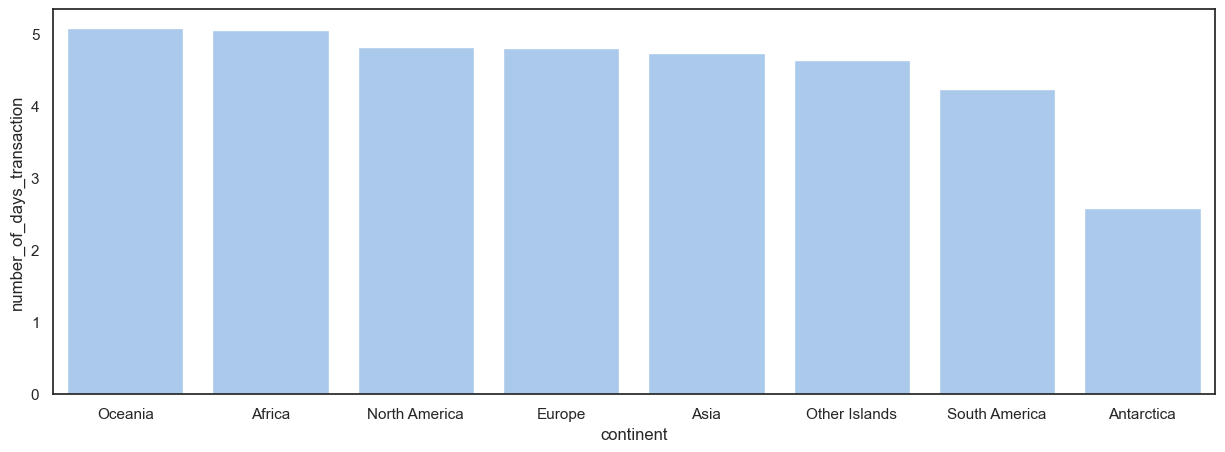

In [84]:
result = checkedout_only.groupby(['continent'])['number_of_days_transaction'].mean().reset_index().sort_values('number_of_days_transaction', ascending=False)
display(result)
plt.figure(figsize=(15,5))
sns.barplot(result,x='continent',y='number_of_days_transaction')

#### 4.3.6.1 Top 10 Country Revenue

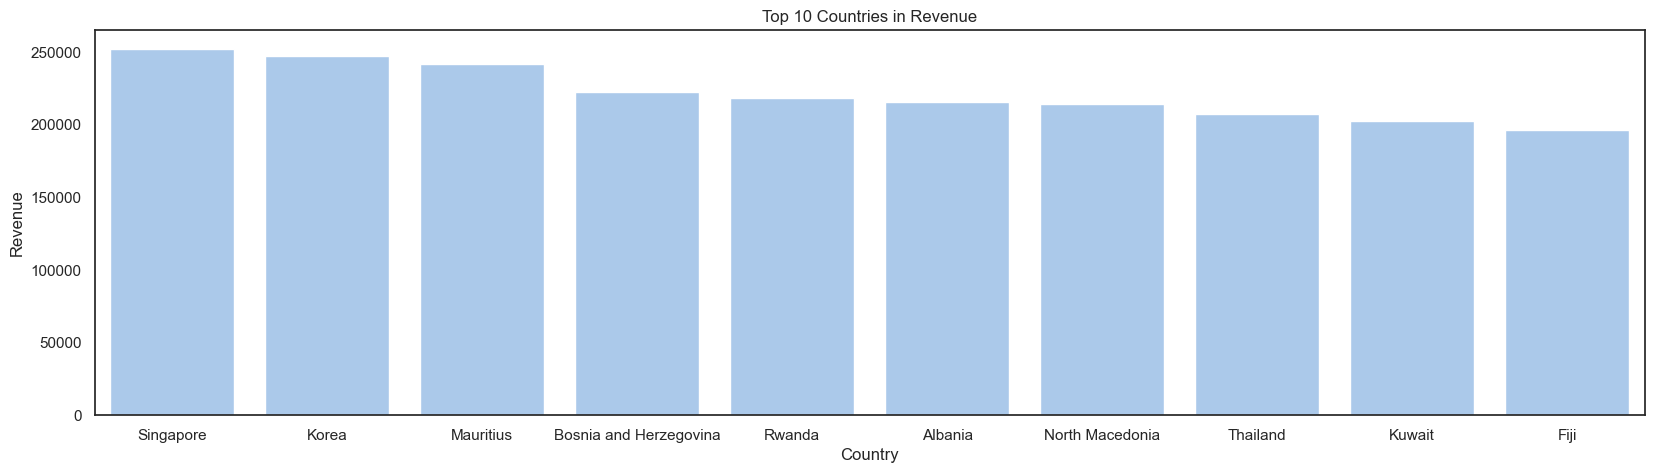

In [85]:
plt.figure(figsize=(20,5))
sns.barplot(data=successful_checkedout_country_total[:10])
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.title('Top 10 Countries in Revenue')
percentages = get_percentages(successful_checkedout_country_total)


**Singapore** is the country with the **highest Revenue contributing 1.11%**

**Korea** though has the **highest amount of Interaction(visits) with the website**, the country is **second** on the list of revenue generation followed by **Mauritius**

 **Slovenia** has the **least revenue generation (<0.01%)** of the revenue generation list 

##### Top 3 Customer Purchase

In [86]:
top3_customers = success_checkout.groupby(
    'customer_id')['total_order_price'].sum().sort_values(ascending=False).index[:3] # gets top 3 customers by revenue``
res = success_checkout[~success_checkout['product_name'].isin(
    success_checkout[success_checkout['customer_id'].isin(
    top3_customers)]['product_name'].unique())]['product_name'].unique()
printmd(f'The **items not purchased** by the top 3 purchasers is **{res[0] if len(res)>0 else "Not Available"}**' )

The **items not purchased** by the top 3 purchasers is **Starbucks Coffee Beans**

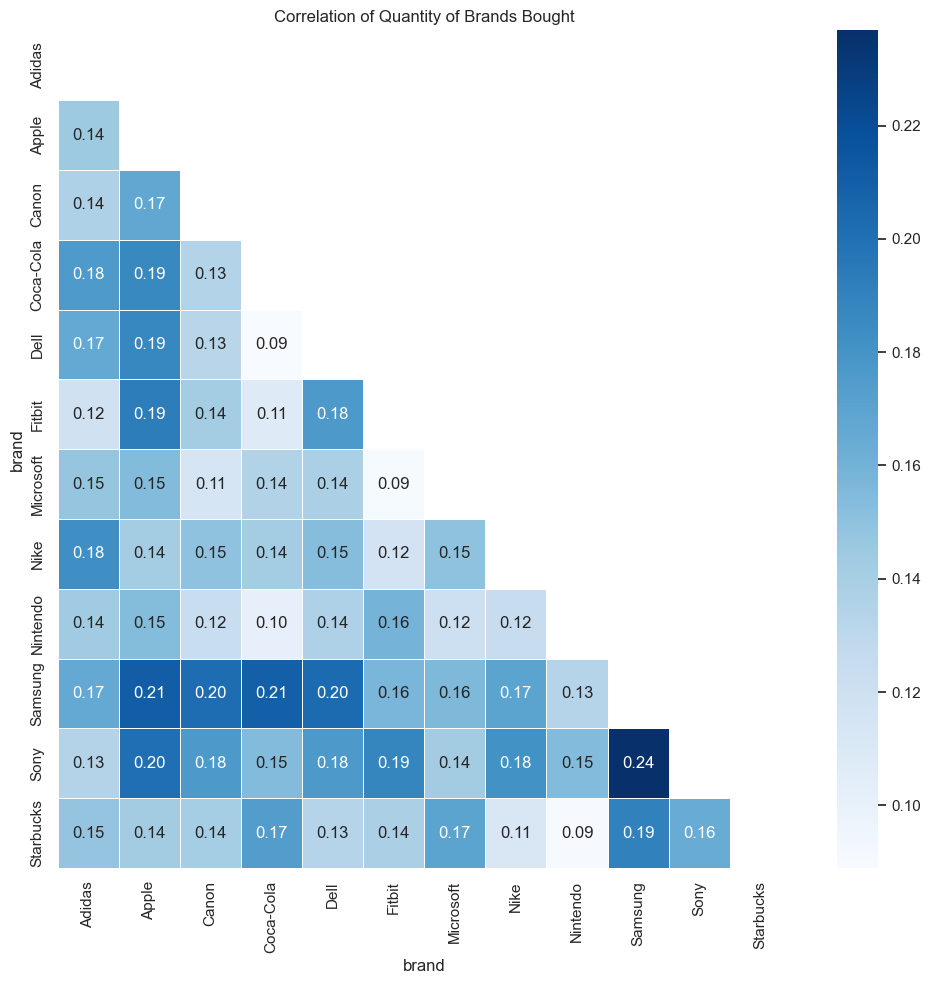

In [87]:
# Correlation of Quantity of Brands Bought
product_corr = pd.pivot_table(success_checkout,columns='brand',index='customer_id',aggfunc='nunique',values='quantity',fill_value=0).corr()
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(product_corr, dtype=bool))
ax = sns.heatmap(product_corr,annot=True,fmt='.2f',mask=mask,linewidth=0.6,cmap='Blues')
ax.set_title("Correlation of Quantity of Brands Bought")
plt.tight_layout()

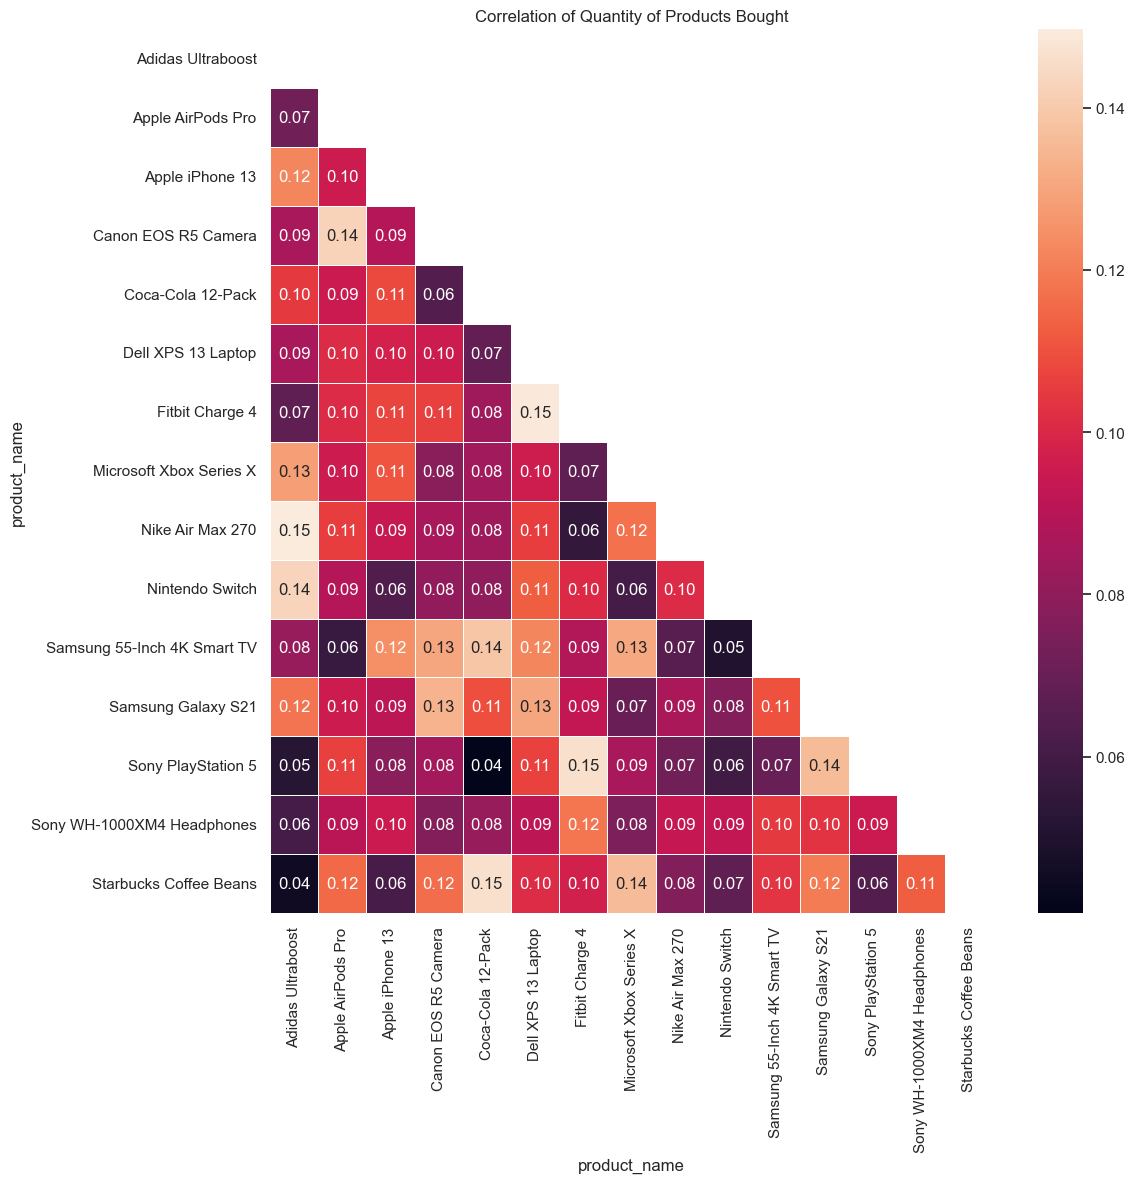

In [88]:
# Correlation of Quantity of Products Bought
product_corr = pd.pivot_table(success_checkout,columns='product_name',index='customer_id',aggfunc='sum',values='quantity',fill_value=0).corr()
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(product_corr, dtype=bool))
ax = sns.heatmap(product_corr,annot=True,fmt='.2f',mask=mask,linewidth=0.6)
ax.set_title('Correlation of Quantity of Products Bought')
plt.tight_layout()

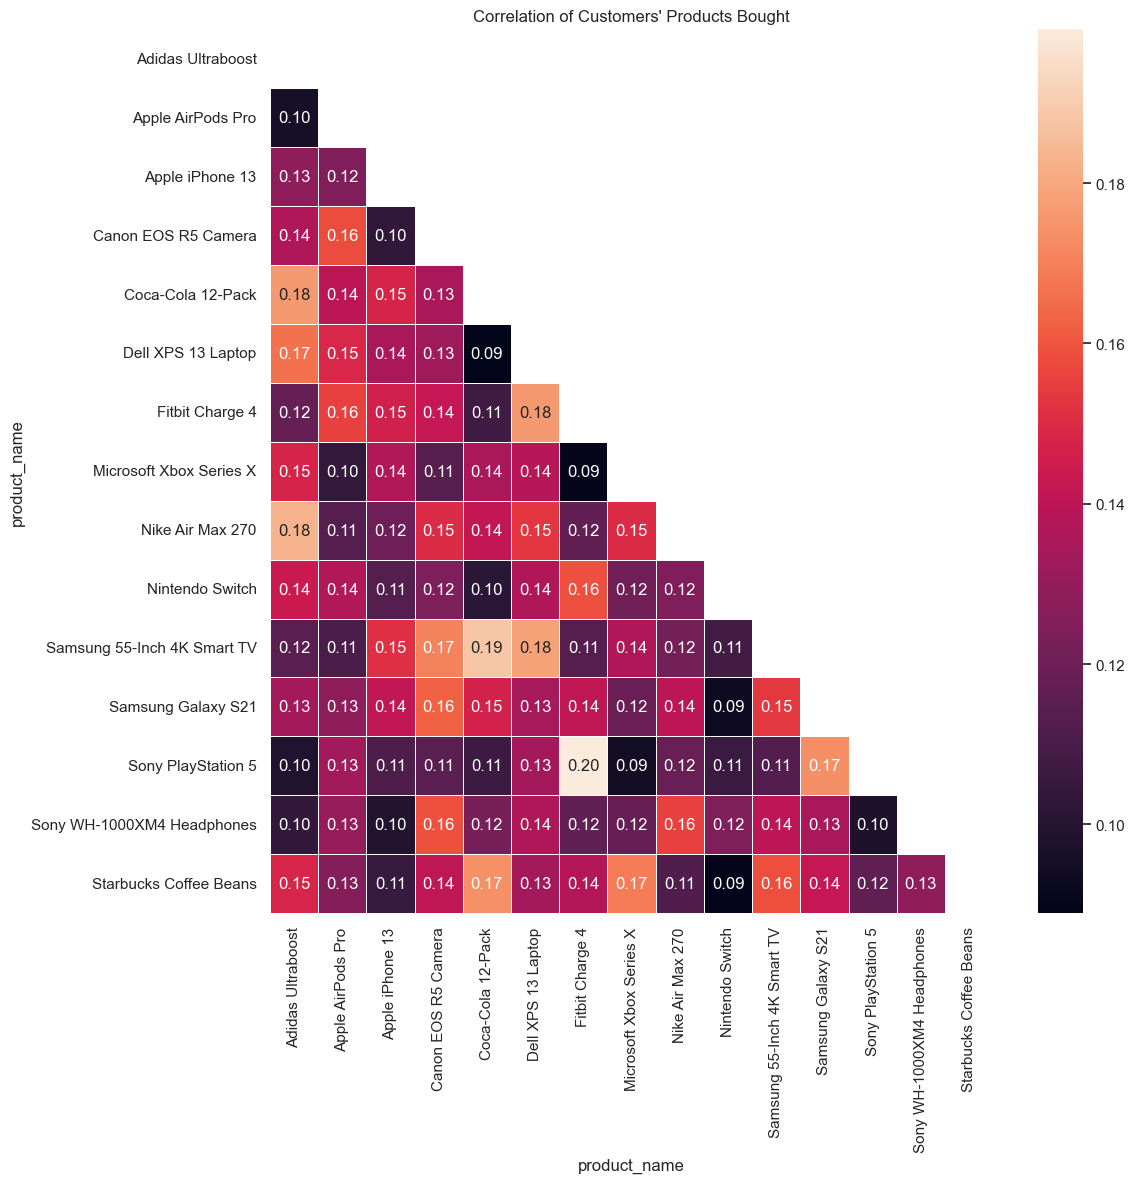

In [89]:
product_corr = pd.pivot_table(success_checkout,columns='product_name',index='customer_id',aggfunc='nunique',values='quantity',fill_value=0).corr()
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(product_corr, dtype=bool))
ax = sns.heatmap(product_corr,annot=True,fmt='.2f',mask=mask,linewidth=0.6)
ax.set_title("Correlation of Customers' Products Bought")
plt.tight_layout()
# product_corr

**Correlation between the quantity of the products bought by customers**

Some of the products that have **slight positive correlation** between 
- **Fitbit Charge 4** and **Sony Playstation**,
- **Coca-Cola 12-Pack** and **Starbucks**
- **Nike Air Max** and **Adidas Ultraboost**

**Correlation between products bought by customers**

Some of the products that have **fair correlation** between 
- **Fitbit Charge 4** and **Sony Playstation**,
- **Coca-Cola 12-Pack** and **Starbucks**
- **Nike Air Max** and **Adidas Ultraboost**
- **Fitbit Charge 4** and **Dell XPS 13 Laptop**

Due to some reasons which can be studied in further analysis, 
correlation between **Sony PlayStation 5** and **Fitbit Charge 4** is higher than every other product followed by<br>correlation between **Samsung 55-Inch 4K Smart TV** and **Coca-Cola 12-Pack**


***For all the correlation above, there is likelihood for a Customer to purchase the pair of the products***

In [90]:
df = new_data[(new_data['status'] == 'success') & (new_data['event_type'] == 'checkout')].groupby('country')['total_order_price'].sum()


fig = go.Figure(data=go.Choropleth(
    locations = df.index,
    locationmode='country names',
    z = df.values,
    # text = df['country'],
    hovertext=df.values,
    colorscale = px.colors.sequential.amp_r,
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'Revenue',
    ))

fig.update_layout(
    title_text='Revenue Generated by Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

**Top Revenue Countries by Continent**

Africa - Libya, Congo and Madagascar

Asia - Korea, Thailand

Europe -  France

Oceania - Australia and New Zealand

South America - Argentina

North America -  Mexico

Antarctica - Antarctica